In [4]:
from google.colab import drive 
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import os
import plotly.express as px
import statsmodels.api as sm

pd.set_option('display.max_columns', None)
##지수식 없애기(e 제거)
np.set_printoptions(precision=6, suppress=True)
pd.options.display.float_format = '{:.5f}'.format

In [ ]:
#!sudo apt-get install -y fonts-nanum
#!sudo fc-cache -fv
#!rm ~/.cache/matplotlib -rf

In [3]:
train = pd.read_csv('/content/gdrive/MyDrive/AI/dataset/집케어 추천 알고리즘/train.csv')
test = pd.read_csv('/content/gdrive/MyDrive/AI/dataset/집케어 추천 알고리즘/test.csv')
sample_submission = pd.read_csv('/content/gdrive/MyDrive/AI/dataset/집케어 추천 알고리즘/sample_submission.csv')

In [ ]:
train_df = train#.drop(['id'], axis = 1)
test_df = test#.drop(['id'], axis = 1)

del train

In [ ]:
def date_processing(df) :
  df['contents_open_dt'] = df['contents_open_dt'].astype('datetime64')

  df['Year'] = df['contents_open_dt'].dt.year 
  df['Month'] = df['contents_open_dt'].dt.month 
  df['Day'] = df['contents_open_dt'].dt.day
  df['hour'] = df['contents_open_dt'].dt.hour
  df['minute'] = df['contents_open_dt'].dt.minute   
  df['second'] = df['contents_open_dt'].dt.second 
  df = df.drop(['contents_open_dt'], axis = 1)


In [ ]:
date_processing(test_df)
test_df = test_df.drop(['contents_open_dt'],axis=1)

date_processing(train_df)
train_df = train_df.drop(['contents_open_dt'],axis=1)

In [ ]:
boo_cols= ['d_l_match_yn', 'd_m_match_yn', 'd_s_match_yn', 'h_l_match_yn', 'h_m_match_yn', 'h_s_match_yn']

train_df[boo_cols] = train_df[boo_cols].applymap(lambda x: 1 if x else 0)
test_df[boo_cols] = test_df[boo_cols].applymap(lambda x: 1 if x else 0)

train_df.head()

,id,d_l_match_yn,d_m_match_yn,d_s_match_yn,h_l_match_yn,h_m_match_yn,h_s_match_yn,person_attribute_a,person_attribute_a_1,person_attribute_b,person_prefer_c,person_prefer_d_1,person_prefer_d_2,person_prefer_d_3,person_prefer_e,person_prefer_f,person_prefer_g,person_prefer_h_1,person_prefer_h_2,person_prefer_h_3,contents_attribute_i,contents_attribute_a,contents_attribute_j_1,contents_attribute_j,contents_attribute_c,contents_attribute_k,contents_attribute_l,contents_attribute_d,contents_attribute_m,contents_attribute_e,contents_attribute_h,person_rn,contents_rn,target,Year,Month,Day,hour,minute,second
0,0,1,1,1,0,0,0,1,4,3,5,275,370,369,8,1,1,4,95,59,3,3,10,2,1,2,1608,275,1,4,139,618822,354805,1,2020,1,17,12,9,36
1,1,0,0,0,1,1,0,1,3,4,1,114,181,175,4,1,1,131,101,96,1,3,5,1,1,2,1608,275,1,4,133,571659,346213,0,2020,6,18,17,48,52
2,2,0,0,0,1,0,0,2,0,3,5,464,175,452,3,1,1,54,263,56,3,1,10,2,1,1,1600,94,1,4,53,399816,206408,0,2020,7,8,20,0,10
3,3,0,0,0,1,0,0,2,0,2,5,703,705,704,3,1,1,72,227,2,1,3,5,1,1,2,1608,275,5,3,74,827967,572323,0,2020,1,13,18,9,34
4,4,1,1,1,0,0,0,1,3,4,5,275,370,369,4,1,1,214,210,209,1,1,10,2,1,2,1608,275,1,4,74,831614,573899,0,2020,3,9,20,39,22


# EDA

In [ ]:
TARGET = 'hour'

target_df = pd.DataFrame(train_df[TARGET].value_counts()).reset_index()
target_df.columns = [TARGET, 'count']
fig = px.bar(data_frame =target_df, 
             x = 'hour',
             y = 'count' , 
             color = "count",
             color_continuous_scale="Emrld") 
fig.show()
target_df.sort_values(by =TARGET , ignore_index = True)

,hour,count
0,0,14147
1,1,9931
2,2,6426
3,3,4446
4,4,3347
5,5,3356
6,6,4859
7,7,8312
8,8,12751
9,9,21908


시각화 후 변수 값이 한 가지만 있는 변수 제거

활동이 적은 시간대 제거

In [ ]:
index0 = train_df[train_df['hour'] == 0].index
index1 = train_df[train_df['hour'] == 1].index
index2 = train_df[train_df['hour'] == 2].index
index3 = train_df[train_df['hour'] == 3].index
index4 = train_df[train_df['hour'] == 4].index
index5 = train_df[train_df['hour'] == 5].index
index6 = train_df[train_df['hour'] == 6].index
index7 = train_df[train_df['hour'] == 7].index
index8 = train_df[train_df['hour'] == 8].index
index9 = train_df[train_df['hour'] == 9].index
index23 = train_df[train_df['hour'] == 23].index
index22 = train_df[train_df['hour'] == 22].index

In [ ]:
train_df = train_df.drop(index0)
train_df = train_df.drop(index1)
train_df = train_df.drop(index2)
train_df = train_df.drop(index3)
train_df = train_df.drop(index4)
train_df = train_df.drop(index5)
train_df = train_df.drop(index6)
train_df = train_df.drop(index7)
train_df = train_df.drop(index8)
train_df = train_df.drop(index9)
train_df = train_df.drop(index23)
train_df = train_df.drop(index22)

In [ ]:
TARGET = 'Day'

target_df = pd.DataFrame(train_df[TARGET].value_counts()).reset_index()
target_df.columns = [TARGET, 'count']
fig = px.bar(data_frame =target_df, 
             x = 'Day',
             y = 'count' , 
             color = "count",
             color_continuous_scale="Emrld") 
fig.show()
target_df.sort_values(by =TARGET , ignore_index = True)

,Day,count
0,1,9257
1,2,12596
2,3,13729
3,4,11514
4,5,11147
5,6,14809
6,7,13408
7,8,11773
8,9,12439
9,10,13785


In [ ]:
train_df = train_df.drop(["person_prefer_f","person_prefer_g","Year"],axis=1)
test_df = test_df.drop(["person_prefer_f","person_prefer_g", "Year"],axis=1)

시간대 합치기

In [ ]:
train_df['time_M'] = train_df['Month']*720
train_df['time_D'] = train_df['Day']*24

time = ['time_M', 'time_D', 'hour']
train_df['time'] = train_df[time].sum(axis=1)
train_df = train_df.drop(['time_M','time_D'],axis=1)

test_df['time_M'] = test_df['Month']*720
test_df['time_D'] = test_df['Day']*24

time = ['time_M', 'time_D', 'hour']
test_df['time'] = test_df[time].sum(axis=1)
test_df = test_df.drop(['time_M','time_D'],axis=1)


In [ ]:
train_df

,id,d_l_match_yn,d_m_match_yn,d_s_match_yn,h_l_match_yn,h_m_match_yn,h_s_match_yn,person_attribute_a,person_attribute_a_1,person_attribute_b,person_prefer_c,person_prefer_d_1,person_prefer_d_2,person_prefer_d_3,person_prefer_e,person_prefer_h_1,person_prefer_h_2,person_prefer_h_3,contents_attribute_i,contents_attribute_a,contents_attribute_j_1,contents_attribute_j,contents_attribute_c,contents_attribute_k,contents_attribute_l,contents_attribute_d,contents_attribute_m,contents_attribute_e,contents_attribute_h,person_rn,contents_rn,target,Month,Day,hour,minute,second,time
0,0,1,1,1,0,0,0,1,4,3,5,275,370,369,8,4,95,59,3,3,10,2,1,2,1608,275,1,4,139,618822,354805,1,1,17,12,9,36,1140
1,1,0,0,0,1,1,0,1,3,4,1,114,181,175,4,131,101,96,1,3,5,1,1,2,1608,275,1,4,133,571659,346213,0,6,18,17,48,52,4769
2,2,0,0,0,1,0,0,2,0,3,5,464,175,452,3,54,263,56,3,1,10,2,1,1,1600,94,1,4,53,399816,206408,0,7,8,20,0,10,5252
3,3,0,0,0,1,0,0,2,0,2,5,703,705,704,3,72,227,2,1,3,5,1,1,2,1608,275,5,3,74,827967,572323,0,1,13,18,9,34,1050
4,4,1,1,1,0,0,0,1,3,4,5,275,370,369,4,214,210,209,1,1,10,2,1,2,1608,275,1,4,74,831614,573899,0,3,9,20,39,22,2396
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501945,501945,0,0,0,1,0,0,2,0,2,1,1128,1092,1224,3,64,65,67,3,1,4,1,1,2,440,147,1,3,65,480565,293985,1,8,10,15,51,14,6015
501946,501946,0,0,0,1,0,0,1,1,2,2,1192,935,1228,3,59,4,95,3,3,5,1,1,2,354,147,1,5,65,503156,285850,1,3,13,12,55,52,2484
501947,501947,1,1,0,1,0,0,1,6,2,1,118,113,110,4,105,142,95,3,3,10,2,1,2,163,120,1,4,142,676255,456996,1,1,20,11,51,51,1211
501948,501948,1,1,1,1,0,0,1,7,4,1,147,46,145,4,59,127,139,3,1,5,1,1,2,438,147,2,7,65,484528,293258,1,8,5,17,27,24,5897


속성별 통계

In [ ]:
len(train_df['contents_attribute_a'].unique())

3

고유값 순위로 변경

In [ ]:
def encode_top(s, count=100, dtype=np.int8):
    # 모든 고유값에 대한 빈도를 계산한다
    uniqs, freqs = np.unique(s, return_counts=True)
    # 빈도 Top 100을 추출한다
    top = sorted(zip(uniqs,freqs), key=lambda vk: vk[1], reverse = True)[:count]
    # { 기존 데이터 : 순위 } 를 나타내는 dict()를 생성한다
    top_map = {uf[0]: l+1 for uf, l in zip(top, range(len(top)))}
    # 고빈도 100개의 데이터는 순위로 대체하고, 그 외는 0으로 대체한다
    return s.map(lambda x: top_map.get(x, 0)).astype(dtype)

In [ ]:
train_df['person_prefer_h_3'] = encode_top(train_df['person_prefer_h_3'], count=100, dtype=np.int8)

Corr

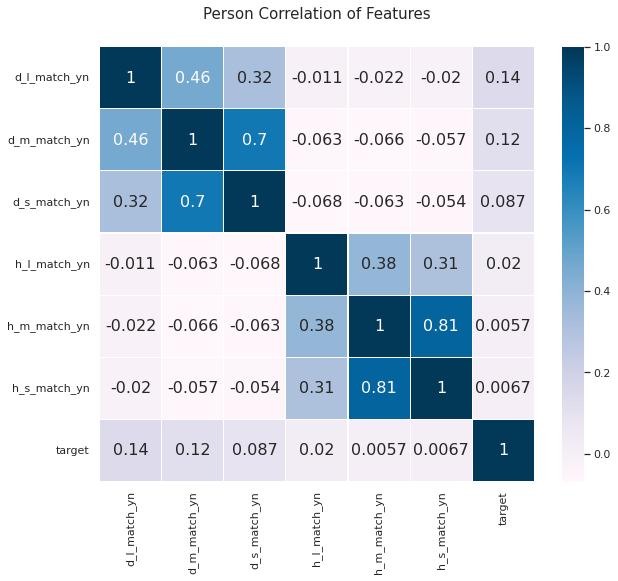

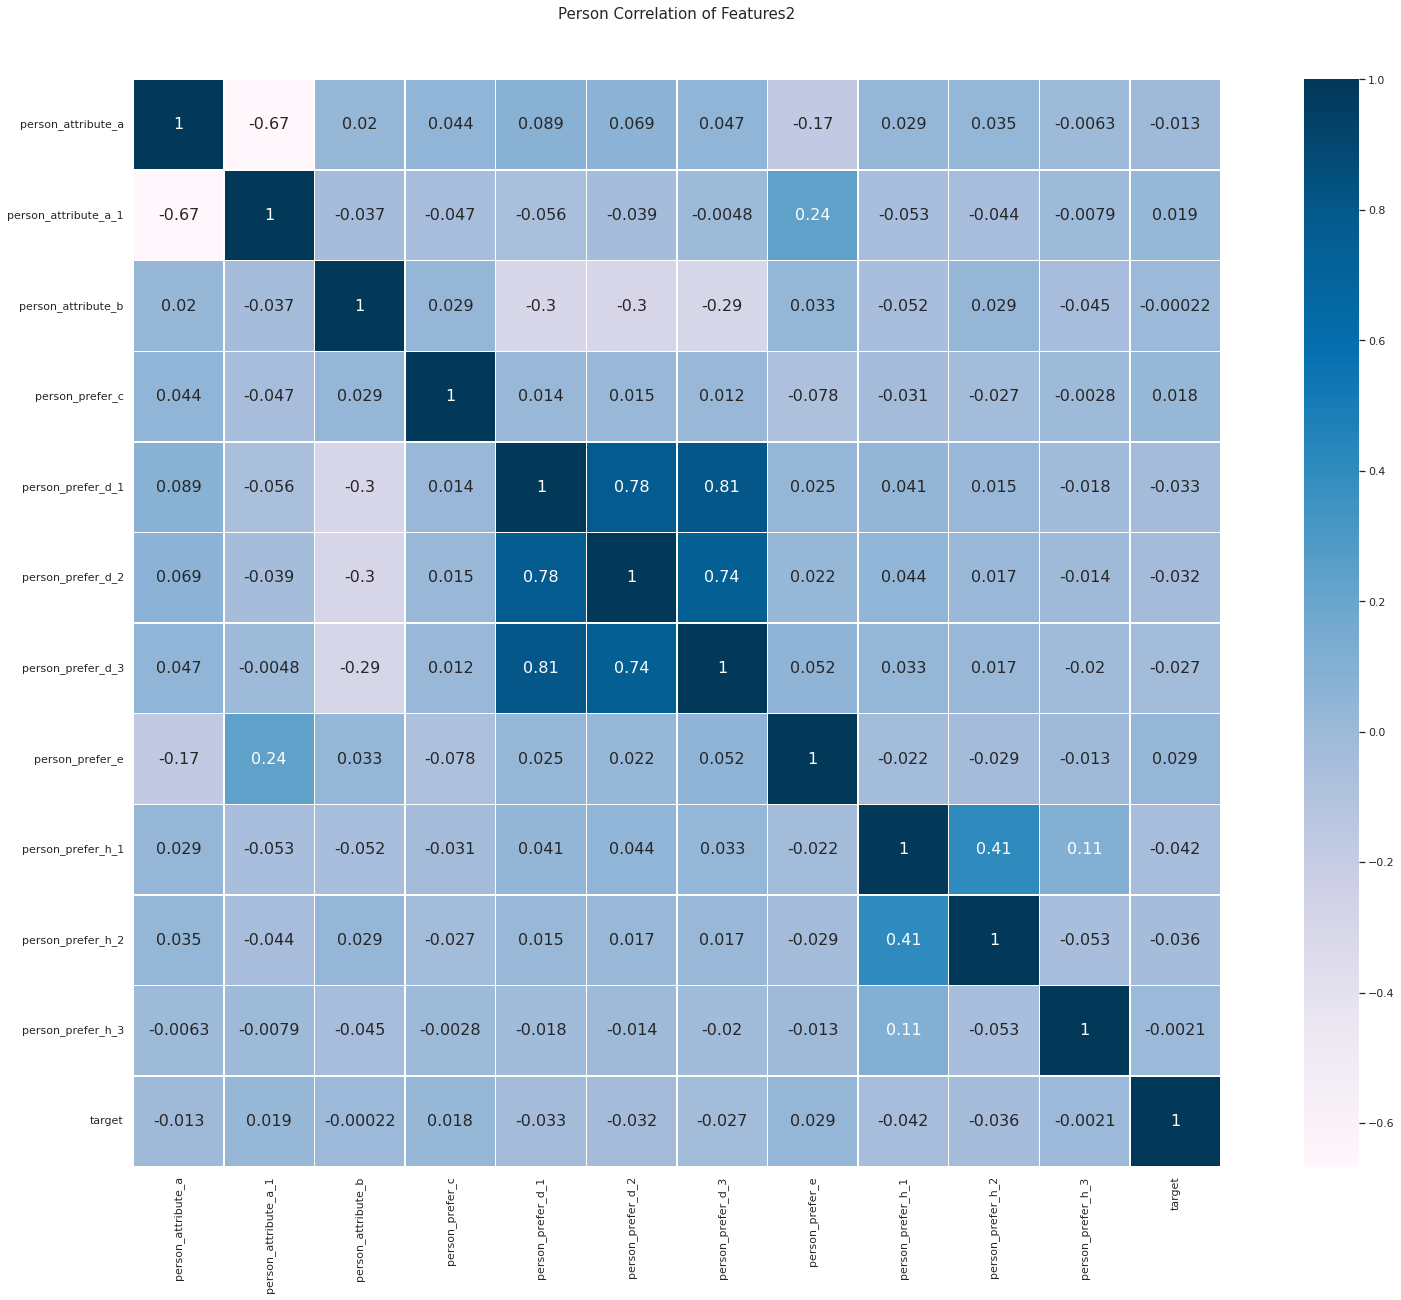

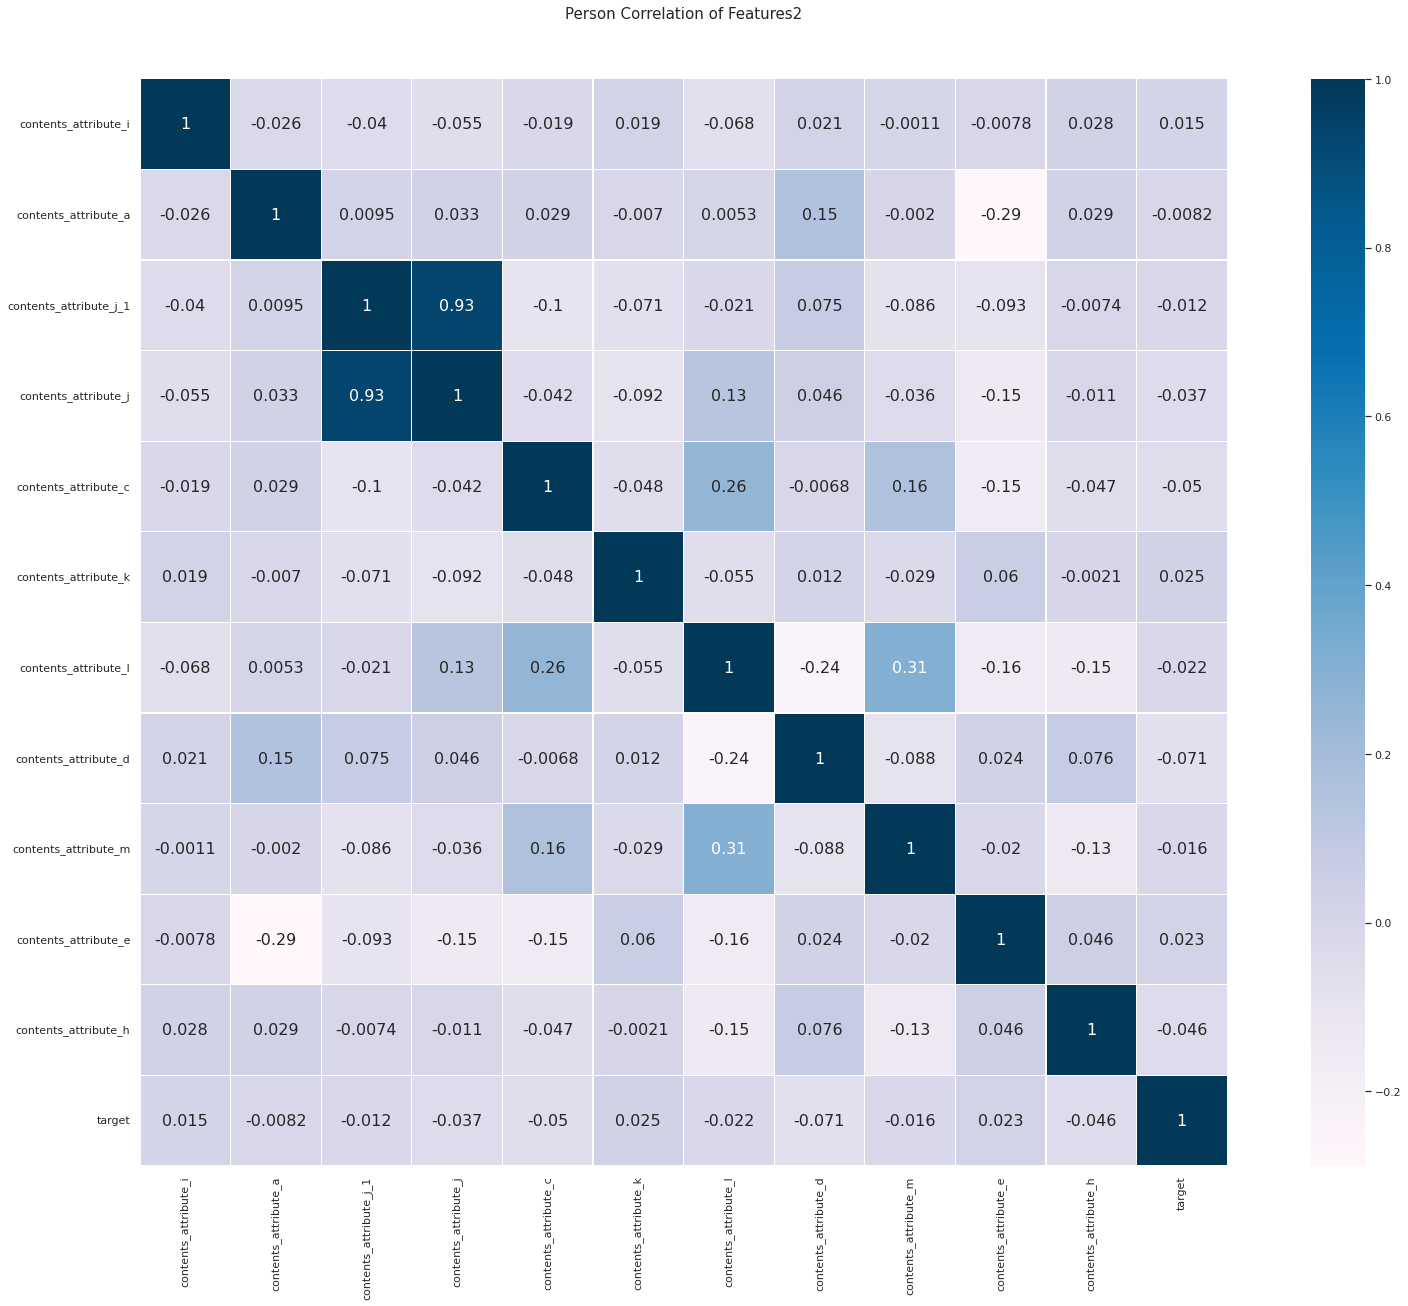

In [ ]:
match = ['d_l_match_yn', 'd_m_match_yn', 'd_s_match_yn', 'h_l_match_yn', 'h_m_match_yn', 'h_s_match_yn', 'target']
person_at = ['person_attribute_a', 'person_attribute_a_1', 
             'person_attribute_b', 'person_prefer_c', 'person_prefer_d_1', 'person_prefer_d_2', 'person_prefer_d_3', 'person_prefer_e', 'person_prefer_h_1', 'person_prefer_h_2', 'person_prefer_h_3', 'target']
contents_at = ['contents_attribute_i', 'contents_attribute_a', 'contents_attribute_j_1', 'contents_attribute_j', 'contents_attribute_c', 'contents_attribute_k', 'contents_attribute_l', 'contents_attribute_d', 'contents_attribute_m', 'contents_attribute_e', 'contents_attribute_h', 'target']             
colormap = plt.cm.PuBu 
plt.figure(figsize=(10, 8)) 
plt.title("Person Correlation of Features", y = 1.05, size = 15) 
sns.heatmap(train_df[match].astype(float).corr(), linewidths = 0.1, vmax = 1.0, 
            square = True, cmap = colormap, linecolor = "white", annot = True, annot_kws = {"size" : 16})
plt.figure(figsize=(10, 8))
plt.gcf().set_size_inches(30, 20) 
plt.title("Person Correlation of Features2", y = 1.05, size = 15) 
sns.heatmap(train_df[person_at].astype(float).corr(), linewidths = 0.3, vmax = 1.0, 
            square = True, cmap = colormap, linecolor = "white", annot = True, annot_kws = {"size" : 16})
plt.figure(figsize=(10, 8))
plt.gcf().set_size_inches(30, 20) 
plt.title("Person Correlation of Features2", y = 1.05, size = 15) 
sns.heatmap(train_df[contents_at].astype(float).corr(), linewidths = 0.3, vmax = 1.0, 
            square = True, cmap = colormap, linecolor = "white", annot = True, annot_kws = {"size" : 16})

In [ ]:
train_df.columns

Index(['id', 'd_l_match_yn', 'd_m_match_yn', 'd_s_match_yn', 'h_l_match_yn',
       'h_m_match_yn', 'h_s_match_yn', 'person_attribute_a',
       'person_attribute_a_1', 'person_attribute_b', 'person_prefer_c',
       'person_prefer_d_1', 'person_prefer_d_2', 'person_prefer_d_3',
       'person_prefer_e', 'person_prefer_h_1', 'person_prefer_h_2',
       'person_prefer_h_3', 'contents_attribute_i', 'contents_attribute_a',
       'contents_attribute_j', 'contents_attribute_c', 'contents_attribute_k',
       'contents_attribute_l', 'contents_attribute_d', 'contents_attribute_m',
       'contents_attribute_e', 'contents_attribute_h', 'person_rn',
       'contents_rn', 'target', 'Month', 'Day', 'hour', 'minute', 'second',
       'time'],
      dtype='object')

In [ ]:
x1 = [ 'd_l_match_yn', 'd_m_match_yn', 'd_s_match_yn', 'h_l_match_yn',
       'h_m_match_yn', 'h_s_match_yn', 'person_attribute_a',
       'person_attribute_a_1','target']
x2 = pd.concat([train_df.iloc[:, 11:20] , train_df['target']], axis = 1)
x3 = pd.concat([train_df.iloc[:, 21:30] , train_df['target']], axis = 1)
x4 = pd.concat([train_df.iloc[:, 31:33] , train_df['target']], axis = 1)

In [ ]:
train_df

,id,d_l_match_yn,d_m_match_yn,d_s_match_yn,h_l_match_yn,h_m_match_yn,h_s_match_yn,person_attribute_a,person_attribute_a_1,person_attribute_b,person_prefer_c,person_prefer_d_1,person_prefer_d_2,person_prefer_d_3,person_prefer_e,person_prefer_h_1,person_prefer_h_2,person_prefer_h_3,contents_attribute_i,contents_attribute_a,contents_attribute_j,contents_attribute_c,contents_attribute_k,contents_attribute_l,contents_attribute_d,contents_attribute_m,contents_attribute_e,contents_attribute_h,person_rn,contents_rn,target,Month,Day,hour,minute,second,time
0,0,1,1,1,0,0,0,1,4,3,5,275,370,369,8,4,95,1,3,3,2,1,2,1608,275,1,4,139,618822,354805,1,1,17,12,9,36,1140
1,1,0,0,0,1,1,0,1,3,4,1,114,181,175,4,131,101,13,1,3,1,1,2,1608,275,1,4,133,571659,346213,0,6,18,17,48,52,4769
2,2,0,0,0,1,0,0,2,0,3,5,464,175,452,3,54,263,37,3,1,2,1,1,1600,94,1,4,53,399816,206408,0,7,8,20,0,10,5252
3,3,0,0,0,1,0,0,2,0,2,5,703,705,704,3,72,227,8,1,3,1,1,2,1608,275,5,3,74,827967,572323,0,1,13,18,9,34,1050
4,4,1,1,1,0,0,0,1,3,4,5,275,370,369,4,214,210,15,1,1,2,1,2,1608,275,1,4,74,831614,573899,0,3,9,20,39,22,2396
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501945,501945,0,0,0,1,0,0,2,0,2,1,1128,1092,1224,3,64,65,34,3,1,1,1,2,440,147,1,3,65,480565,293985,1,8,10,15,51,14,6015
501946,501946,0,0,0,1,0,0,1,1,2,2,1192,935,1228,3,59,4,2,3,3,1,1,2,354,147,1,5,65,503156,285850,1,3,13,12,55,52,2484
501947,501947,1,1,0,1,0,0,1,6,2,1,118,113,110,4,105,142,2,3,3,2,1,2,163,120,1,4,142,676255,456996,1,1,20,11,51,51,1211
501948,501948,1,1,1,1,0,0,1,7,4,1,147,46,145,4,59,127,18,3,1,1,1,2,438,147,2,7,65,484528,293258,1,8,5,17,27,24,5897


In [ ]:
sns.pairplot(train_df, hue="target", size=3)

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:2076: UserWarning:

The `size` parameter has been renamed to `height`; please update your code.



중복값 확인

In [ ]:
#train_df = train_df.drop_duplicates(['contents_rn','hour'], keep='first')
#test_df = test_df.drop_duplicates(['contents_rn','hour'], keep='first')

In [ ]:
len(train_df)

476939

카테고리 타입 선언

In [ ]:
category = ['d_l_match_yn','d_m_match_yn','d_s_match_yn','h_l_match_yn','h_m_match_yn', 'h_s_match_yn','person_attribute_a', 'person_attribute_a_1', 'person_attribute_b', 'person_prefer_c', 'person_prefer_e', 'contents_attribute_i', 'contents_attribute_a', 'contents_attribute_j_1', 'contents_attribute_j', 'contents_attribute_c', 'contents_attribute_k', 'contents_attribute_m', 'contents_attribute_e']
train_df[category] = train_df[category].astype('category')
test_df[category] = test_df[category].astype('category')

#카테고리 타입 'd_l_match_yn','d_m_match_yn','d_s_match_yn','h_l_match_yn','h_m_match_yn', 'h_s_match_yn','person_attribute_a', 'person_attribute_a_1', 'person_attribute_b', 'person_prefer_c', 'person_prefer_e', 'contents_attribute_i', 'contents_attribute_a', 'contents_attribute_j_1', 'contents_attribute_j', 'contents_attribute_c', 'contents_attribute_k', 'contents_attribute_m', 'contents_attribute_e'

# Light GBM

In [ ]:
X = train_df.drop(['target','id'], axis=1)
y = train_df['target']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=0) # train, valid 8.5:1.5 분할

In [ ]:
from lightgbm  import LGBMClassifier

In [ ]:
rgbm = LGBMClassifier(random_state=0)
rgbm.fit(X_train, y_train, eval_set=(X_valid, y_valid),  eval_metric='auc')
y_pred = rgbm.predict(X_valid)

[1]	valid_0's binary_logloss: 0.688401	valid_0's auc: 0.621454
[2]	valid_0's binary_logloss: 0.68451	valid_0's auc: 0.624792
[3]	valid_0's binary_logloss: 0.681317	valid_0's auc: 0.62646
[4]	valid_0's binary_logloss: 0.678609	valid_0's auc: 0.627842
[5]	valid_0's binary_logloss: 0.676388	valid_0's auc: 0.628261
[6]	valid_0's binary_logloss: 0.674336	valid_0's auc: 0.631103
[7]	valid_0's binary_logloss: 0.672623	valid_0's auc: 0.632064
[8]	valid_0's binary_logloss: 0.671176	valid_0's auc: 0.63235
[9]	valid_0's binary_logloss: 0.669923	valid_0's auc: 0.632876
[10]	valid_0's binary_logloss: 0.668888	valid_0's auc: 0.633395
[11]	valid_0's binary_logloss: 0.667911	valid_0's auc: 0.634231
[12]	valid_0's binary_logloss: 0.667036	valid_0's auc: 0.634913
[13]	valid_0's binary_logloss: 0.666286	valid_0's auc: 0.635514
[14]	valid_0's binary_logloss: 0.6656	valid_0's auc: 0.63636
[15]	valid_0's binary_logloss: 0.665023	valid_0's auc: 0.636669
[16]	valid_0's binary_logloss: 0.664477	valid_0's auc: 

In [ ]:
#y_pred = (y_pred>0.5)*1
y_pred

array([0, 0, 0, ..., 0, 1, 0], dtype=int64)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_pred, y_valid))

              precision    recall  f1-score   support

           0       0.55      0.63      0.59     23762
           1       0.69      0.61      0.65     32125

    accuracy                           0.62     55887
   macro avg       0.62      0.62      0.62     55887
weighted avg       0.63      0.62      0.62     55887



In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score 
f1 = f1_score(y_valid, y_pred)
AUC = accuracy_score(y_valid, y_pred)
print(f1)
print(AUC)

#0.63458065493856
#0.61570132681657

#0.6316096029173419
#0.6135895767202795

#0.6350376946293046
#0.6161528960195503

#0.6478267343933553
#0.619142197648827

0.6487299410005123
0.619678995115143


findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


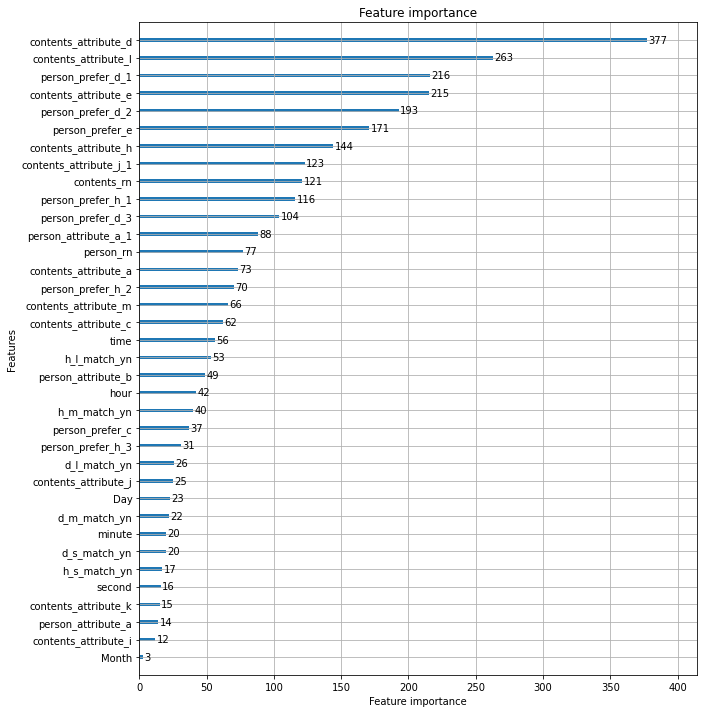

In [ ]:
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

plt.rc('font', family='NanumBarunGothic')
fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(rgbm, ax=ax)

In [ ]:
test_df = test_df.drop(['id'],axis=1)

In [ ]:
LGBM_prediction = rgbm.predict(test_df)
sample_submission['id'] = test['id']
sample_submission['target'] = LGBM_prediction

In [ ]:
sample_submission

,id,target
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
46399,46399,1
46400,46400,1
46401,46401,1
46402,46402,1


In [ ]:
sample_submission.to_csv('/content/gdrive/MyDrive/AI/dataset/집케어 추천 알고리즘/LGBM4.csv', index=False)

# CatBoost

In [ ]:
X = train_df.drop('target', axis=1)
y = train_df['target']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=0) # train, valid 8:2 분할

In [ ]:
!pip install catboost
from catboost import CatBoostClassifier

In [ ]:
#cat_params = {
    #'iterations': 15000,
    #'learning_rate': 0.03,
    #'od_wait': 1000,
    #'depth': 7,
    #'task_type' : 'GPU',
    #'devices' : '0',
    #'verbose' : 1000
#}
is_holdout = False
n_splits = 5
iterations = 3000
patience = 50
SEED = 42
cat = CatBoostClassifier(iterations=iterations,random_state=SEED,task_type="GPU",eval_metric="F1",cat_features=category,one_hot_max_size=4)
cat.fit(X_train, y_train, eval_set=(X_valid, y_valid), early_stopping_rounds=patience , verbose = 100 )

Learning rate set to 0.027698
0:	learn: 0.6302518	test: 0.6318821	best: 0.6318821 (0)	total: 47ms	remaining: 2m 21s
bestTest = 0.6373798443
bestIteration = 1
Shrink model to first 2 iterations.


In [ ]:
from sklearn.metrics import classification_report,confusion_matrix

y_pred = cat.predict(X_valid)
print(classification_report(y_valid,y_pred))

              precision    recall  f1-score   support

           0       0.64      0.89      0.75     27503
           1       0.83      0.52      0.64     28384

    accuracy                           0.70     55887
   macro avg       0.74      0.70      0.69     55887
weighted avg       0.74      0.70      0.69     55887



In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
f1 = f1_score(y_valid, y_pred)
print(f1)

0.637379844286895


In [ ]:
sample_submission

,id,target
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
46399,46399,1
46400,46400,0
46401,46401,1
46402,46402,1


In [ ]:
CatBoost_prediction = cat.predict(test_df)
sample_submission['id'] = test['id']
sample_submission['target'] = CatBoost_prediction

In [ ]:
sample_submission

,id,target
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
46399,46399,1
46400,46400,0
46401,46401,1
46402,46402,1


In [ ]:
sample_submission.to_csv('/content/gdrive/MyDrive/AI/dataset/집케어 추천 알고리즘/Cat.csv', index=False)

# ANN

In [ ]:
# Keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras import backend as K
from tensorflow.keras.layers import Dropout
from keras import callbacks
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import SGD
# Scoring
from sklearn.metrics import confusion_matrix, accuracy_score, plot_confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score,classification_report

In [ ]:
test_df.columns

Index(['id', 'd_l_match_yn', 'd_m_match_yn', 'd_s_match_yn', 'h_l_match_yn',
       'h_m_match_yn', 'h_s_match_yn', 'person_attribute_a',
       'person_attribute_a_1', 'person_attribute_b', 'person_prefer_c',
       'person_prefer_d_1', 'person_prefer_d_2', 'person_prefer_d_3',
       'person_prefer_e', 'person_prefer_h_1', 'person_prefer_h_2',
       'person_prefer_h_3', 'contents_attribute_i', 'contents_attribute_a',
       'contents_attribute_j_1', 'contents_attribute_j',
       'contents_attribute_c', 'contents_attribute_k', 'contents_attribute_l',
       'contents_attribute_d', 'contents_attribute_m', 'contents_attribute_e',
       'contents_attribute_h', 'person_rn', 'contents_rn', 'Month', 'Day',
       'hour', 'minute', 'second', 'time'],
      dtype='object')

In [ ]:
featrues = test_df.columns

scaler = MinMaxScaler()
scaler.fit(train_df[featrues])

train_df[featrues] = scaler.fit_transform(train_df[featrues])
X_test = scaler.transform(test_df)

In [ ]:
X = train_df.drop(['target','id'], axis=1)
y = train_df['target']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=0) # train, valid 8:2 분할

# freeing up some memory
del train_df

In [ ]:
X_valid

,d_l_match_yn,d_m_match_yn,d_s_match_yn,h_l_match_yn,h_m_match_yn,h_s_match_yn,person_attribute_a,person_attribute_a_1,person_attribute_b,person_prefer_c,person_prefer_d_1,person_prefer_d_2,person_prefer_d_3,person_prefer_e,person_prefer_h_1,person_prefer_h_2,person_prefer_h_3,contents_attribute_i,contents_attribute_a,contents_attribute_j_1,contents_attribute_j,contents_attribute_c,contents_attribute_k,contents_attribute_l,contents_attribute_d,contents_attribute_m,contents_attribute_e,contents_attribute_h,person_rn,contents_rn,Month,Day,hour,minute,second,time
272195,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.71429,0.60000,0.00000,0.39713,0.36683,0.14115,0.36364,0.98714,1.00000,0.03000,1.00000,1.00000,0.44444,0.00000,0.00000,1.00000,0.88419,0.14115,0.75000,0.27273,0.99673,0.88433,0.87118,0.80000,0.06667,0.72727,0.84746,0.64407,0.73555
331520,1.00000,0.00000,0.00000,1.00000,0.00000,0.00000,1.00000,0.00000,0.40000,0.00000,0.74083,0.86762,0.25917,0.27273,0.30225,0.00643,0.18000,1.00000,0.50000,0.44444,0.00000,0.00000,1.00000,0.28777,0.97767,0.00000,0.27273,0.43791,0.53359,0.45045,1.00000,0.96667,0.63636,0.57627,0.35593,0.99949
340423,0.00000,0.00000,0.00000,1.00000,1.00000,1.00000,0.00000,0.85714,0.40000,1.00000,0.08772,0.09330,0.06858,0.36364,0.48553,0.47588,0.51000,0.50000,1.00000,1.00000,1.00000,0.00000,1.00000,0.50050,0.60606,0.00000,0.27273,0.48366,0.77070,0.74248,0.50000,0.60000,0.54545,0.32203,0.88136,0.51069
228429,1.00000,1.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.42857,0.60000,0.00000,0.11404,0.03349,0.11244,0.54545,0.18328,0.29904,0.03000,1.00000,0.00000,0.44444,0.00000,0.00000,0.00000,0.29076,0.11563,0.00000,0.36364,0.20588,0.48540,0.42402,0.50000,0.73333,0.72727,0.40678,0.42373,0.52308
488212,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.42857,0.80000,0.00000,0.11563,0.07815,0.11244,0.36364,0.33441,0.36656,0.13000,1.00000,0.50000,0.44444,0.00000,0.66667,1.00000,0.58698,0.97528,0.75000,0.36364,0.05556,0.60687,0.09564,0.90000,0.50000,0.54545,0.74576,0.81356,0.86582
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411689,1.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.42857,0.40000,0.00000,0.14115,0.13636,0.08772,0.36364,0.13505,0.11254,0.21000,0.00000,1.00000,1.00000,1.00000,0.00000,1.00000,0.79672,0.12520,0.75000,0.36364,0.10131,0.13355,0.10678,0.50000,0.53333,0.45455,0.50847,0.69492,0.50449
74720,1.00000,1.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.14286,0.40000,0.00000,0.56938,0.57018,0.58692,0.27273,0.37621,0.42765,0.03000,1.00000,0.50000,0.88889,1.00000,0.00000,1.00000,0.91004,0.56938,0.75000,0.27273,0.03595,0.99575,0.04997,0.00000,0.93333,0.45455,0.88136,0.27119,0.08562
269293,1.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.85714,0.60000,0.75000,0.09091,0.08852,0.07496,0.36364,0.09325,0.88746,0.04000,1.00000,1.00000,0.55556,1.00000,0.66667,1.00000,0.90109,0.07177,0.00000,0.36364,0.10458,0.13924,0.13505,1.00000,0.50000,0.72727,0.94915,0.22034,0.95713
169931,0.00000,0.00000,0.00000,1.00000,1.00000,0.00000,0.00000,0.85714,0.40000,1.00000,0.00638,0.68022,0.08692,0.36364,0.31833,0.41479,0.13000,0.00000,1.00000,0.44444,0.00000,0.00000,1.00000,0.51839,0.68022,1.00000,0.27273,0.31699,0.68750,0.65583,0.40000,0.26667,0.72727,0.69492,0.71186,0.38953


In [ ]:
import keras 
from tensorflow.keras import layers 
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

model = keras.Sequential([ 
    layers.BatchNormalization(),
    layers.Dense(2048, activation='sigmoid', input_shape=[101]),
    layers.Dropout(rate = 0.3), 
    layers.BatchNormalization(),    
    layers.Dense(2048, activation='sigmoid'), 
    layers.Dropout(rate = 0.3), 
    layers.BatchNormalization(),
    layers.Dense(2048, activation='sigmoid'), 
    layers.Dropout(rate = 0.3), 
    layers.Dense(1, activation = 'sigmoid'), 
]) 

early_stopping = EarlyStopping(min_delta = 0.001, patience = 10, restore_best_weights = True)
reducedlr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

model.compile( 
    optimizer='adamax', 
    loss='binary_crossentropy', 
    metrics=['AUC'],
    )

In [ ]:
prediction = model.fit( 
    X_train, y_train, 
    validation_data=(X_valid, y_valid), 
    batch_size=256, 
    epochs=100, 
    callbacks = [
                early_stopping,reducedlr], 
    verbose = 2, 
)

Epoch 1/100
1238/1238 - 11s - loss: 0.7124 - auc: 0.5608 - val_loss: 0.6750 - val_auc: 0.6140 - lr: 0.0010 - 11s/epoch - 9ms/step
Epoch 2/100
1238/1238 - 9s - loss: 0.6796 - auc: 0.5967 - val_loss: 0.6755 - val_auc: 0.6145 - lr: 0.0010 - 9s/epoch - 7ms/step
Epoch 3/100
1238/1238 - 9s - loss: 0.6783 - auc: 0.6003 - val_loss: 0.6792 - val_auc: 0.6151 - lr: 0.0010 - 9s/epoch - 7ms/step
Epoch 4/100
1238/1238 - 9s - loss: 0.6781 - auc: 0.6010 - val_loss: 0.6773 - val_auc: 0.6150 - lr: 0.0010 - 9s/epoch - 7ms/step
Epoch 5/100
1238/1238 - 9s - loss: 0.6776 - auc: 0.6021 - val_loss: 0.6739 - val_auc: 0.6168 - lr: 0.0010 - 9s/epoch - 7ms/step
Epoch 6/100
1238/1238 - 9s - loss: 0.6771 - auc: 0.6031 - val_loss: 0.6724 - val_auc: 0.6189 - lr: 0.0010 - 9s/epoch - 7ms/step
Epoch 7/100
1238/1238 - 9s - loss: 0.6759 - auc: 0.6058 - val_loss: 0.6721 - val_auc: 0.6214 - lr: 0.0010 - 9s/epoch - 8ms/step
Epoch 8/100
1238/1238 - 9s - loss: 0.6740 - auc: 0.6107 - val_loss: 0.6751 - val_auc: 0.6276 - lr: 0.0

In [ ]:
# summarize history for acc
plt.plot(model.model['auc'])
plt.plot(model.model['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(model.model['loss'])
plt.plot(model.model['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

AttributeError: ignored

In [ ]:
preds = model.predict(X_valid)
preds = (preds[:,0]>0.5)*1

In [ ]:
preds

array([0, 0, 0, ..., 0, 1, 0])

In [ ]:
print(classification_report(y_valid,preds))

              precision    recall  f1-score   support

           0       0.61      0.53      0.57     27503
           1       0.60      0.68      0.64     28384

    accuracy                           0.61     55887
   macro avg       0.61      0.60      0.60     55887
weighted avg       0.61      0.61      0.60     55887



In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score 
f1 = f1_score(y_valid, pred)
AUC = accuracy_score(y_valid, pred)
print(f1)
print(AUC)

0.6315877251501001
0.6047381323026823


In [ ]:
test_df[scale_col] = scaler.transform(test_df[scale_col])

In [ ]:
ann_pred2 = model.predict(test_df)

In [ ]:
ann_pred2 = [ 1 if y>=0.5 else 0 for y in ann_pred2]

In [ ]:
ann_pred2

In [ ]:
sample_submission2 = pd.read_csv('/content/gdrive/MyDrive/AI/dataset/집케어 추천 알고리즘/sample_submission.csv')
sub = pd.read_csv('/content/gdrive/MyDrive/AI/dataset/집케어 추천 알고리즘/sample_submission.csv')
sample_submission2['target'] = ann_pred2
sample_submission2['target'] = sample_submission2['target'] .astype('int64')
sample_submission2['id'] = test['id'] 

In [ ]:
sub['target'] = (sample_submission['target'] * 0.4 + sample_submission2['target']*0.6)
sub['target'] = sub['target'] .astype('int64')

In [ ]:
sub.to_csv('/content/gdrive/MyDrive/AI/dataset/집케어 추천 알고리즘/Weight3.csv',index=False)

# 평균 앙상블 

In [ ]:
LGBM_prediction

NameError: ignored

In [ ]:
ann_pred2 = (0.5*ann_pred2)

In [ ]:
LGBM_prediction = (0.5*LGBM_prediction)

In [ ]:
weight = ann_pred2+LGBM_prediction

In [ ]:
w_average = (0.5*ann_pred2 + 0.5*LGBM_prediction)

del ann_pred2
del LGBM_prediction

TypeError: ignored

In [ ]:
weight

array([[0.5, 0.5, 0.5, ..., 1. , 1. , 1. ],
       [0.5, 0.5, 0.5, ..., 1. , 1. , 1. ],
       [0.5, 0.5, 0.5, ..., 1. , 1. , 1. ],
       ...,
       [0.5, 0.5, 0.5, ..., 1. , 1. , 1. ],
       [0.5, 0.5, 0.5, ..., 1. , 1. , 1. ],
       [0.5, 0.5, 0.5, ..., 1. , 1. , 1. ]])

In [ ]:
weight = [ 1 if y>=0.5 else 0 for y in weight]

ValueError: ignored

In [ ]:
ann_pred2